# Classification model to predict students' dropout and academic sucess.

The dataset contains information collected from a higher education institution related to students undertaking different degree programs.
The original dataset contains information known at the time of student enrollment and the student's academic perfromance at the end of the 1st and 2nd semester.

The target is split into three distinct categories namely Dropout, Enrolled and Graduate.

In this spirit, I shall build classification models using various architectures to predict the student's dropout and academic success.This can then be used to predict which students are most likely to drop out at an early stage so that strategies can be put in place to counter this.

That would help reduce the rate of academic dropout and failure.

## Import Libraries and Datasets

### Libraries

## Imports

Below, i import all the libraries and datasets needed for this competition.

In [1]:
%pip install -Uqq fastbook


Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install catboost
%pip install optuna
%pip install optuna_distributed
%pip install openfe
%pip install xgboost


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import fastbook
fastbook.setup_book()

In [6]:
#hide
#! [ -e /content ]

#hide
#This imports and sets up everything you will need for this notebook
#
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#from fastbook import *
#!pip install ucimlrepo
#from ucimlrepo import fetch_ucirepo

from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import numpy as np
from numpy import random

from fastai.imports import *
np.set_printoptions(linewidth=130)


from pathlib import Path
import os


from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import roc_auc_score,accuracy_score,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score
#from sklearn.metrics import root_mean_squared_error

import xgboost as xgb
from xgboost import plot_importance

import lightgbm as lgb

from catboost import CatBoostClassifier,CatBoostRegressor,Pool, metrics, cv

from ipywidgets import interact


matplotlib.rc('image', cmap='Greys')

#from fastkaggle import setup_comp

import optuna
from openfe import OpenFE, transform

from IPython.display import FileLink

#from lightgbm import LGBMClassifier



In [5]:
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [7]:
%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [8]:
!ls

fastai-gbms-decisionTrees.ipynb  fastai-gradient-boosting.ipynb.amltmp
fastai-gradient-boosting.ipynb	 kaggle.json


In [8]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

#!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/home/azureuser/.kaggle’: File exists


In [11]:
comp = 'playground-series-s4e6'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

100%|██████████| 3.07M/3.07M [00:00<00:00, 8.91MB/s]


In [18]:
!ls academic_dataset/

data.csv  sample_submission.csv  test.csv  train.csv


In [14]:
#!mkdir academic_dataset

In [16]:
! kaggle datasets download -d rubanzasilva/academic-success-dataset
!unzip academic-success-dataset.zip -d academic_dataset/
!unzip playground-series-s4e6.zip -d academic_dataset/

Dataset URL: https://www.kaggle.com/datasets/rubanzasilva/academic-success-dataset
License(s): Apache 2.0
  0%|                                                | 0.00/105k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 105k/105k [00:00<00:00, 1.43MB/s]
Archive:  academic-success-dataset.zip
  inflating: academic_dataset/data.csv  
Archive:  playground-series-s4e6.zip
  inflating: academic_dataset/sample_submission.csv  
  inflating: academic_dataset/test.csv  
  inflating: academic_dataset/train.csv  


## Import Datasets

In [9]:
path = Path('academic_dataset/')
path

Path('academic_dataset')

In [10]:
train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')
sub_df = pd.read_csv(path/'sample_submission.csv')
#original_df = pd.read_csv(path/'data.csv')

In [ ]:
#X = train_df.drop(columns=["Target"], axis=1)
#y = train_df["Target"]

#y.shape, X.shape

# Baseline

Previously, i had built a baseline model using AutoML solution AutoGluon without presets, this gave me an initial submission score of 0.83434.Find the notebook [here](https://www.kaggle.com/code/rubanzasilva/autogluon-starter).

In this notebook, i test out different model architectures and data transformation to try to improve on the baseline score.

# Without original dataset

First i shall try out the models using only the data initially provided to us, without the original dataset.

Below i use the fastai tabular methods to preprocess and prepare my data for machine learning, creating training and a validation set.

Use the fastai cont_cat_split to separate my dataset variables into categorical and continous variables.

I then use randomsplitter to do a random split and create a validation set of about 20% of the initial dataset.



In [11]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='Target')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Target',
                   y_block=CategoryBlock(),
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_df)

# Trying out different model architectures.

Here i start with decision trees specifically random forests, then i try out gradient boosting models catboost, xgboost and light GBMs.

Later on i try out neural networks and an ensemble of various neural networks using the fastai library.

## Random Forests

In [12]:
%%time
rf = RandomForestClassifier(100, min_samples_leaf=3)
rf_model_a = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model_a.predict(test_dl.xs))

rf_preds_x = tensor(rf_model_a.predict(X_test))

#mse = mean_absolute_error(y_test, rf_preds_x)
#rmse = np.sqrt(mse)

accuracy_score(y_test,rf_preds_x)

CPU times: user 10.6 s, sys: 11.3 ms, total: 10.7 s
Wall time: 10.7 s


0.8295759001502974

## Cat Preds

In [13]:
%%time
cat_model = CatBoostClassifier(iterations=2000, depth=8, learning_rate=  0.08, random_strength=10)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))


cat_preds_final = cat_preds.squeeze(1)

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

cat_preds_x_final = cat_preds_x.squeeze(1)

accuracy_score(y_test,cat_preds_x)

CPU times: user 5min 34s, sys: 6.1 s, total: 5min 40s
Wall time: 1min 33s


0.8331046200091485

## XGBoost

In [14]:
xgb_model = xgb.XGBClassifier(n_estimators = 197, max_depth=4, learning_rate=0.1818695751227044, subsample= 0.39774994666482544)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

accuracy_score(y_test,xgb_preds_x)

0.8325818466967261

## LGBM

In [15]:
lgb_model = lgb.LGBMClassifier(num_leaves=251, learning_rate=0.02956613668999794, n_estimators=483, max_depth=82, boosting_type='gbdt',min_child_samples=90, random_state=27)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))

lgb_score = accuracy_score(y_test,lgb_preds_x)
lgb_score

0.8306867934391949

In [16]:
model_preds = {
    "random forests":accuracy_score(y_test,rf_preds_x),
    "cat boost":accuracy_score(y_test,cat_preds_x),
    "lgbm":lgb_score,
    "xgboost":accuracy_score(y_test,xgb_preds_x),   
}

#model_preds_a = model_preds.sort()
print(model_preds)

{'random forests': 0.8295759001502974, 'cat boost': 0.8331046200091485, 'lgbm': 0.8306867934391949, 'xgboost': 0.8325818466967261}


{'random forests': 0.826439260275763, 'cat boost': 0.8316016467359342, 'lgbm': 0.8306214467751422, 'xgboost': 0.8299679801346141}

In [ ]:
mapping = dict(enumerate(dls.vocab))
mapping

## Submission

In [ ]:
lgb_preds.shape,cat_preds.shape,cat_preds_final.shape

In [17]:
mapping = dict(enumerate(dls.vocab))
predicted_labels = [mapping[value.item()] for value in cat_preds_final]
submit = pd.read_csv(path/'sample_submission.csv')
submit.Target = predicted_labels
submit.to_csv('submission.csv',index=False)
submit

,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Enrolled
4,76522,Enrolled
...,...,...
51007,127525,Dropout
51008,127526,Dropout
51009,127527,Dropout
51010,127528,Dropout


In [18]:
!ls

academic-success-dataset.zip	       kaggle.json
academic_dataset		       models
catboost_info			       playground-series-s4e6
dataset				       playground-series-s4e6.zip
fastai-gbms-decisionTrees.ipynb        requirements.txt
fastai-gradient-boosting.ipynb	       submission.csv
fastai-gradient-boosting.ipynb.amltmp


In [19]:
!kaggle competitions submit -c playground-series-s4e6 -f submission.csv -m "cat preds without original dataset"

100%|████████████████████████████████████████| 759k/759k [00:00<00:00, 2.66MB/s]
Successfully submitted to Classification with an Academic Success Dataset

In [32]:
!rm submission.csv

### Neural Network

SuggestedLRs(slide=0.03981071710586548, valley=0.0020892962347716093)

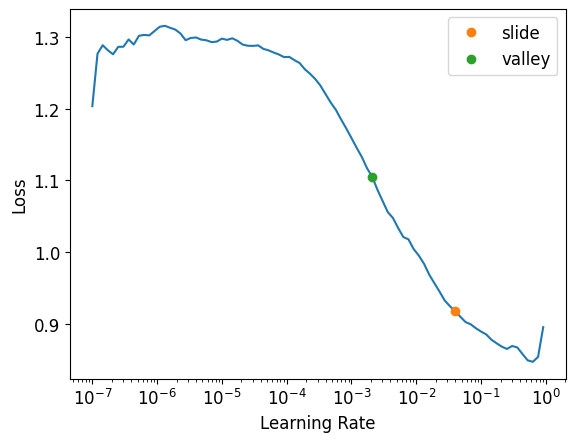

In [21]:
learn = tabular_learner(dls, metrics=accuracy)
learn.lr_find(suggest_funcs=(slide,valley))

In [22]:
%%time
learn.fit_one_cycle(10,0.02)

epoch,train_loss,valid_loss,accuracy,time
0,0.492063,0.464946,0.821669,00:08
1,0.484078,0.477918,0.823433,00:08
2,0.458066,0.483228,0.816637,00:08
3,0.479600,0.455533,0.830752,00:08
4,0.476044,0.463359,0.816833,00:08
5,0.460973,0.445521,0.829053,00:08
6,0.447599,0.443554,0.829053,00:08
7,0.442403,0.441513,0.830164,00:08
8,0.445365,0.441101,0.830621,00:08
9,0.442001,0.439757,0.831210,00:08


CPU times: user 2min 14s, sys: 900 ms, total: 2min 14s
Wall time: 1min 25s


In [23]:
dl = learn.dls.test_dl(test_df)

In [24]:
%%time
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)
nn_preds_b = a_preds[:, 0]

CPU times: user 10.5 s, sys: 55.9 ms, total: 10.5 s
Wall time: 7.56 s


In [28]:
nn_preds_x.shape,nn_preds_y.shape,a_preds.shape

(torch.Size([15303, 3]), torch.Size([51012, 3]), torch.Size([51012, 3]))

In [26]:
nn_preds_b = a_preds[:, 0]
nn_preds_b.shape

torch.Size([51012])

In [30]:
nn_preds_b

tensor([0.9906, 0.0026, 0.0110,  ..., 0.9961, 0.9889, 0.9963])

In [33]:
mapping = dict(enumerate(dls.vocab))
#predicted_labels = [mapping[value.item()] for value in general_preds_sub]
# Assuming general_preds_sub contains the averaged predictions from multiple models
rounded_preds = torch.round(nn_preds_b).long()  # Round to nearest whole number and convert to long type

# Now map the rounded predictions to labels
predicted_labels = [mapping[value.item()] for value in rounded_preds]
submit = pd.read_csv(path/'sample_submission.csv')
submit.Target = predicted_labels
submit.to_csv('submission.csv',index=False)
submit

,id,Target
0,76518,Enrolled
1,76519,Dropout
2,76520,Dropout
3,76521,Dropout
4,76522,Dropout
...,...,...
51007,127525,Enrolled
51008,127526,Enrolled
51009,127527,Enrolled
51010,127528,Enrolled


In [35]:
!kaggle competitions submit -c playground-series-s4e6 -f submission.csv -m "nn preds without original dataset - round off preds"

100%|████████████████████████████████████████| 739k/739k [00:00<00:00, 2.63MB/s]
Successfully submitted to Classification with an Academic Success Dataset

In [34]:
!ls

academic-success-dataset.zip	       kaggle.json
academic_dataset		       models
catboost_info			       playground-series-s4e6
dataset				       playground-series-s4e6.zip
fastai-gbms-decisionTrees.ipynb        requirements.txt
fastai-gradient-boosting.ipynb	       submission.csv
fastai-gradient-boosting.ipynb.amltmp


In [36]:
!rm submission.csv

In [ ]:
mapping = dict(enumerate(dls.vocab))
predicted_labels = [mapping[value.item()] for value in cat_preds_final]
submit = pd.read_csv(path/'sample_submission.csv')
submit.Target = predicted_labels
submit.to_csv('submission.csv',index=False)
submit

### Ensemble

For testing with our accuracy_score metric, we use the x preds as in lgb_preds_x, xgboost_preds_x,rf_preds_x, and cat_preds_x_final.

For submission, we use the lgb_preds, xgboost_preds,rf_preds, and cat_preds_final as this is the result of running the model on the initial test set and gives us the same shape as our expected submission.

#### For testing

In [ ]:
cat_preds_x_final = cat_preds_x.squeeze(1)

In [ ]:
rf_preds_x.shape,cat_preds_x_final.shape,lgb_preds_x.shape,xgb_preds_x.shape

In [ ]:
general_preds = (rf_preds_x + cat_preds_x_final + lgb_preds_x + xgb_preds_x)/4
general_preds

In [ ]:
rf_preds_x.shape,cat_preds_x_final.shape,lgb_preds_x.shape,xgb_preds_x.shape,general_preds.shape

In [ ]:
accuracy_score(y_test,general_preds)

#### For Submission

In [27]:
rf_preds.shape,cat_preds_final.shape,lgb_preds.shape,xgb_preds.shape,nn_preds_x.shape,nn_preds_b.shape

(torch.Size([51012]),
 torch.Size([51012]),
 torch.Size([51012]),
 torch.Size([51012]),
 torch.Size([15303, 3]),
 torch.Size([51012]))

In [28]:
general_preds_sub = (rf_preds + cat_preds_final + lgb_preds + xgb_preds + nn_preds_b)/5
general_preds_sub

tensor([0.1945, 1.6006, 1.6038,  ..., 0.1983, 0.1812, 0.1924])

In [33]:
general_preds_sub = ( cat_preds_final + lgb_preds + xgb_preds)/3
general_preds_sub

tensor([0., 2., 2.,  ..., 0., 0., 0.])

In [ ]:
rf_preds.shape,cat_preds_final.shape,lgb_preds.shape,xgb_preds.shape,general_preds_sub.shape

The general_preds_sub contains numbers that are floats, yet our targets are encoded among 3 whole numbers, hence it throws a keyerror when trying to do the mapping. 

To solve this, i experiment with rounding off which doesnt seem to drop the accuracy.

In [34]:
mapping = dict(enumerate(dls.vocab))
predicted_labels = [mapping[value.item()] for value in general_preds_sub]

KeyError: 1.6666666269302368

In [35]:
mapping = dict(enumerate(dls.vocab))
#predicted_labels = [mapping[value.item()] for value in general_preds_sub]
# Assuming general_preds_sub contains the averaged predictions from multiple models
rounded_preds = torch.round(general_preds_sub).long()  # Round to nearest whole number and convert to long type

# Now map the rounded predictions to labels
predicted_labels = [mapping[value.item()] for value in rounded_preds]
submit = pd.read_csv(path/'sample_submission.csv')
submit.Target = predicted_labels
submit.to_csv('submission.csv',index=False)
submit

,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Enrolled
4,76522,Enrolled
...,...,...
51007,127525,Dropout
51008,127526,Dropout
51009,127527,Dropout
51010,127528,Dropout


In [36]:
!kaggle competitions submit -c playground-series-s4e6 -f submission.csv -m "(general preds - rfpreds,nn_preds) without original dataset - round off preds"

100%|████████████████████████████████████████| 759k/759k [00:00<00:00, 2.77MB/s]
400 - Bad Request - Submission not allowed:  Your team has used its daily Submission allowance (5) today, please try again tomorrow UTC (13 hours from now).


# Adding original dataset

In [5]:
original_df = pd.read_csv(path/'data.csv', delimiter=';')

In [6]:
original_df.rename(columns={'Daytime/evening attendance\t':'Daytime/evening attendance'}, inplace=True)

In [7]:
train_final = pd.concat([train_df,original_df], axis=0)
test_final = pd.concat([test_df,original_df], axis=0)

In [28]:
cont_names,cat_names = cont_cat_split(train_final, dep_var='Target')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_final))
to = TabularPandas(train_final, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Target',
                   y_block=CategoryBlock(),
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

dls = to.dataloaders(bs=64)
#test_dl = dls.test_dl(test_df)

In [9]:
test_dl = dls.test_dl(test_df)

In [10]:
%%time
rf = RandomForestClassifier(100, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

accuracy_score(y_test,rf_preds_x)

CPU times: user 12.2 s, sys: 12 ms, total: 12.2 s
Wall time: 12.2 s


0.8230170496664195

{'random forests': 0.8236293537214925, 'cat boost': 0.8265699536038685, 'lgbm': 0.8253283669868653, 'xgboost': 0.8268313402600798}

In [11]:
%%time
cat_model = CatBoostClassifier(iterations=2000, depth=8, learning_rate=  0.08, random_strength=10)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))


cat_preds_final = cat_preds.squeeze(1)

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

cat_preds_x_final = cat_preds_x.squeeze(1)

accuracy_score(y_test,cat_preds_x)

CPU times: user 6min 13s, sys: 6.41 s, total: 6min 19s
Wall time: 1min 48s


0.8254880158141833

In [12]:
%%time
xgb_model = xgb.XGBClassifier(n_estimators = 197, max_depth=4, learning_rate=0.1818695751227044, subsample= 0.39774994666482544)
xgb_model = xgb_model.fit(X_train, y_train)
xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

accuracy_score(y_test,xgb_preds_x)

CPU times: user 6.33 s, sys: 51 ms, total: 6.38 s
Wall time: 10.9 s


0.8275883370397825

In [13]:
lgb_model = lgb.LGBMClassifier(num_leaves=251, learning_rate=0.02956613668999794, n_estimators=483, max_depth=82, boosting_type='gbdt',min_child_samples=90, random_state=27)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))

lgb_score = accuracy_score(y_test,lgb_preds_x)
lgb_score

0.8257968865826538

In [14]:
!ls

academic-success-dataset.zip	 fastai-gradient-boosting.ipynb.amltmp
academic_dataset		 kaggle.json
catboost_info			 models
dataset				 playground-series-s4e6
fastai-gbms-decisionTrees.ipynb  playground-series-s4e6.zip
fastai-gradient-boosting.ipynb	 requirements.txt


In [27]:
!rm submission.csv

In [15]:
model_preds = {
    "random forests":accuracy_score(y_test,rf_preds_x),
    "cat boost":accuracy_score(y_test,cat_preds_x),
    "lgbm":lgb_score,
    "xgboost":accuracy_score(y_test,xgb_preds_x),   
}

#model_preds_a = model_preds.sort()
print(model_preds)

{'random forests': 0.8230170496664195, 'cat boost': 0.8254880158141833, 'lgbm': 0.8257968865826538, 'xgboost': 0.8275883370397825}


In [16]:
mapping = dict(enumerate(dls.vocab))
predicted_labels = [mapping[value.item()] for value in xgb_preds]
submit = pd.read_csv(path/'sample_submission.csv')
submit.Target = predicted_labels
submit.to_csv('submission.csv',index=False)
submit

,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Enrolled
4,76522,Enrolled
...,...,...
51007,127525,Dropout
51008,127526,Dropout
51009,127527,Dropout
51010,127528,Dropout


In [17]:
!kaggle competitions submit -c playground-series-s4e6 -f submission.csv -m "xgb preds without original dataset"

100%|████████████████████████████████████████| 759k/759k [00:00<00:00, 2.51MB/s]
Successfully submitted to Classification with an Academic Success Dataset

# Optuna

In [17]:
def objective_catboost(trial):
    params = {
        "iterations": 200,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "random_strength": trial.suggest_int("random_strength", 1, 10),
    }
    cat_model = CatBoostClassifier(**params, silent=True)
    cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
    cat_predictions = cat_model.predict(X_test)
    cat_accuracy = accuracy_score(y_test,cat_predictions)
    return cat_accuracy

study_catboost = optuna.create_study(direction='minimize')
study_catboost.optimize(objective_catboost, n_trials=100)
print(study_catboost.best_params)

[I 2024-06-12 20:13:06,917] A new study created in memory with name: no-name-12dfd30e-e715-4e6d-a333-0b381e147d8d
[I 2024-06-12 20:13:11,531] Trial 0 finished with value: 0.8172253806443182 and parameters: {'learning_rate': 0.020485004274482965, 'depth': 6, 'random_strength': 8}. Best is trial 0 with value: 0.8172253806443182.
[I 2024-06-12 20:13:23,242] Trial 1 finished with value: 0.8177481539567405 and parameters: {'learning_rate': 0.017908321530146706, 'depth': 8, 'random_strength': 10}. Best is trial 0 with value: 0.8172253806443182.
[I 2024-06-12 20:13:26,635] Trial 2 finished with value: 0.8152649807227341 and parameters: {'learning_rate': 0.019022634218488852, 'depth': 3, 'random_strength': 5}. Best is trial 2 with value: 0.8152649807227341.
[I 2024-06-12 20:13:41,444] Trial 3 finished with value: 0.8272887669084493 and parameters: {'learning_rate': 0.0351221304311505, 'depth': 9, 'random_strength': 2}. Best is trial 2 with value: 0.8152649807227341.
[I 2024-06-12 20:13:44,976]

{'learning_rate': 0.011509434380214512, 'depth': 1, 'random_strength': 10}


In [18]:
print(study_catboost.best_params)

{'learning_rate': 0.011509434380214512, 'depth': 1, 'random_strength': 10}


In [22]:
%%time

def objective_lgbm(trial):
    params = {
            'num_leaves': trial.suggest_int('num_leaves', 100, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 300, 1200),
            'subsample_for_bin': trial.suggest_int('subsample_for_bin', 20000, 300000),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
            'subsample': trial.suggest_float('subsample', 0.25, 1.0),
            'max_depth': trial.suggest_int('max_depth', 1, 15)
            }

    lgb_model = lgb.LGBMClassifier(**params,verbose=False)
    lgb_model.fit(X_train, y_train)
    lgb_predictions = lgb_model.predict(X_test)
    lgb_accuracy = accuracy_score(y_test,lgb_predictions)
    return lgb_accuracy


study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=100)
print(study_lgbm.best_params)

[I 2024-06-12 20:22:46,266] A new study created in memory with name: no-name-397048e9-1d0a-456b-9894-875926c30577
[LightGBM] [Fatal] Parameter verbosity should be of type int, got "False"
[W 2024-06-12 20:22:46,288] Trial 0 failed with parameters: {'num_leaves': 238, 'learning_rate': 0.6663005203433919, 'n_estimators': 509, 'subsample_for_bin': 87104, 'min_child_samples': 336, 'reg_alpha': 6.025291954240299e-09, 'reg_lambda': 4.549618576432364e-06, 'colsample_bytree': 0.6903505950645896, 'subsample': 0.8982925661067045, 'max_depth': 2} because of the following error: LightGBMError('Parameter verbosity should be of type int, got "False"').
Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<timed exec>", line 16, in objective_lgbm
  File "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/lightgbm/sklearn.py", line 967, in fit
   

LightGBMError: Parameter verbosity should be of type int, got "False"

In [ ]:
print(study_lgbm.best_params)

In [23]:
def objective_xgboost(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
    }
    xgb_model = xgb.XGBClassifier(**params)
    xgb_model.fit(X_train, y_train)
    xgb_predictions = xgb_model.predict(X_test)
    xgb_accuracy = accuracy_score(y_test,xgb_predictions)
    return xgb_accuracy

study_xgboost = optuna.create_study(direction='minimize')
study_xgboost.optimize(objective_xgboost, n_trials=150)
print(study_xgboost.best_params)

[I 2024-06-12 20:22:51,951] A new study created in memory with name: no-name-2efb85a1-b6cb-49b5-8c39-d3b574ac96e6
[I 2024-06-12 20:22:54,272] Trial 0 finished with value: 0.8334966999934653 and parameters: {'n_estimators': 120, 'max_depth': 7, 'learning_rate': 0.12572657266615828, 'subsample': 0.7711827724598136}. Best is trial 0 with value: 0.8334966999934653.
[I 2024-06-12 20:22:57,499] Trial 1 finished with value: 0.8285303535254526 and parameters: {'n_estimators': 125, 'max_depth': 9, 'learning_rate': 0.014787100402184606, 'subsample': 0.18191208594213898}. Best is trial 1 with value: 0.8285303535254526.
[I 2024-06-12 20:23:03,242] Trial 2 finished with value: 0.8301640201267725 and parameters: {'n_estimators': 149, 'max_depth': 10, 'learning_rate': 0.0247905921409569, 'subsample': 0.7909186864625259}. Best is trial 1 with value: 0.8285303535254526.
[I 2024-06-12 20:23:05,016] Trial 3 finished with value: 0.8286610468535581 and parameters: {'n_estimators': 161, 'max_depth': 3, 'lea

{'n_estimators': 102, 'max_depth': 1, 'learning_rate': 0.01726624156431896, 'subsample': 0.11977439657701404}


In [24]:
print(study_xgboost.best_params)

{'n_estimators': 102, 'max_depth': 1, 'learning_rate': 0.01726624156431896, 'subsample': 0.11977439657701404}


In [25]:
print(study_catboost.best_params)

{'learning_rate': 0.011509434380214512, 'depth': 1, 'random_strength': 10}


In [ ]:
!ls

In [26]:
%%time
cat_model = CatBoostClassifier(iterations=2000, depth=1, learning_rate= 0.011509434380214512, random_strength=10)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))


cat_preds_final = cat_preds.squeeze(1)

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

cat_preds_x_final = cat_preds_x.squeeze(1)

accuracy_score(y_test,cat_preds_x)

CPU times: user 1min 23s, sys: 1.4 s, total: 1min 24s
Wall time: 22.2 s


0.8221263804482781

In [27]:
%%time
xgb_model = xgb.XGBClassifier(n_estimators = 102, max_depth=1, learning_rate=0.01726624156431896, subsample= 0.11977439657701404)
xgb_model = xgb_model.fit(X_train, y_train)
xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

accuracy_score(y_test,xgb_preds_x)

CPU times: user 2.13 s, sys: 29 µs, total: 2.13 s
Wall time: 1.08 s


0.7919362216558845

In [ ]:
lgb_model = lgb.LGBMClassifier(num_leaves=251, learning_rate=0.02956613668999794, n_estimators=483, max_depth=82, boosting_type='gbdt',min_child_samples=90, random_state=27)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))

lgb_score = accuracy_score(y_test,lgb_preds_x)
lgb_score

In [28]:
mapping = dict(enumerate(dls.vocab))
predicted_labels = [mapping[value.item()] for value in cat_preds_final]
submit = pd.read_csv(path/'sample_submission.csv')
submit.Target = predicted_labels
submit.to_csv('submission.csv',index=False)
submit

,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Graduate
4,76522,Enrolled
...,...,...
51007,127525,Dropout
51008,127526,Dropout
51009,127527,Dropout
51010,127528,Dropout


In [29]:
!kaggle competitions submit -c playground-series-s4e6 -f submission.csv -m "cat preds without original dataset with optuna"

100%|████████████████████████████████████████| 759k/759k [00:00<00:00, 2.70MB/s]
Successfully submitted to Classification with an Academic Success Dataset

In [36]:
%%time
cat_model = CatBoostClassifier(iterations=2000, depth=9, learning_rate=  0.1319687641202529, random_strength=1)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))


cat_preds_final = cat_preds.squeeze(1)

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

cat_preds_x_final = cat_preds_x.squeeze(1)

accuracy_score(y_test,cat_preds_x)

CPU times: user 7min 28s, sys: 7.92 s, total: 7min 36s
Wall time: 2min 16s


0.8250016336666013

In [37]:
mapping = dict(enumerate(dls.vocab))
predicted_labels = [mapping[value.item()] for value in cat_preds_final]
submit = pd.read_csv(path/'sample_submission.csv')
submit.Target = predicted_labels
submit.to_csv('submission.csv',index=False)
submit

,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Graduate
4,76522,Enrolled
...,...,...
51007,127525,Dropout
51008,127526,Dropout
51009,127527,Dropout
51010,127528,Dropout


In [38]:
!kaggle competitions submit -c playground-series-s4e6 -f submission.csv -m "cat preds without original dataset + optuna"

# Adding Base Features

from https://www.kaggle.com/code/trupologhelper/ps4e5-openfe-blending-explain#Creating-New-Features-%F0%9F%93%8A

In [ ]:
BASE_FEATURES = test_final.columns
initial_features = BASE_FEATURES
initial_features

In [ ]:
%%time
for df in [train_final, test_final]:
    print('comnputing f_sum')
    df['fsum'] = df[initial_features].sum(axis=1) # for tree models
    print('comnputing f_std')
    df['f_std']  = df[initial_features].std(axis=1)
    print('comnputing f_mean')
    df['f_mean'] = df[initial_features].mean(axis=1)
    print('comnputing f_max')
    df['f_max']  = df[initial_features].max(axis=1)
    print('comnputing f_min')
    df['f_min']  = df[initial_features].min(axis=1)
    print('comnputing f_mode')
    df['f_mode'] = df[initial_features].mode(axis=1)[0]
    print('comnputing f_median')
    df['f_median'] = df[initial_features].median(axis=1)
    print('comnputing f_25th')
    df['f_25th'] = df[initial_features].quantile(0.25, axis=1)
    print('comnputing f_75th')
    df['f_75th'] = df[initial_features].quantile(0.75, axis=1)
    print('comnputing f_skew')
    df['f_skew'] = df[initial_features].skew(axis=1)
    print('comnputing f_kurt')
    df['f_kurt'] = df[initial_features].kurt(axis=1)
    df['special1'] = df['fsum'].isin(np.arange(72, 76)) # for linear models
    for i in range(10,100,10):
        print(f'comnputing f_{i}th')
        df[f'f_{i}th'] = df[initial_features].quantile(i/100, axis=1)
    print('comnputing f_harmonic')
    df['f_harmonic'] = len(initial_features) / df[initial_features].apply(lambda x: (1/x).mean(), axis=1)
    print('comnputing f_geometric')
    df['f_geometric'] = df[initial_features].apply(lambda x: x.prod()**(1/len(x)), axis=1)
    print('comnputing f_zscore')
    df['f_zscore'] = df[initial_features].apply(lambda x: (x - x.mean()) / x.std(), axis=1).mean(axis=1)
    print('computing Coefficient of Variation ')
    df['f_cv'] = df[initial_features].std(axis=1) / df[initial_features].mean(axis=1)
    print('computing f_Quantile Coefficients of Skewness_75')
    df['f_Quantile Coefficients of Skewness_75'] = (df[initial_features].quantile(0.75, axis=1) - df[initial_features].mean(axis=1)) / df[initial_features].std(axis=1)
    print('computing f_Quantile Coefficients of Skewness_25')
    df['f_Quantile Coefficients of Skewness_25'] = (df[initial_features].quantile(0.25, axis=1) - df[initial_features].mean(axis=1)) / df[initial_features].std(axis=1)
    print('computing f_2ndMoment')
    df['f_2ndMoment'] = df[initial_features].apply(lambda x: (x**2).mean(), axis=1)
    print('computing f_3rdMoment')
    df['f_3rdMoment'] = df[initial_features].apply(lambda x: (x**3).mean(), axis=1)
    print('computing f_entropy')
    df['f_entropy'] = df[initial_features].apply(lambda x: -1*(x*np.log(x)).sum(), axis=1)
    #print('computing f_mad') probably has negative impact
    #df['f_mad'] = df[initial_features].apply(lambda x: (x - x.median()).abs().median(), axis=1)
    #print('computing f_iqr') probably has negative impact
    #df['f_iqr'] = df[initial_features].quantile(0.75, axis=1) - df[initial_features].quantile(0.25, axis=1)

In [ ]:
train_final.head()

## Neural Network Ensemble

In [ ]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy)
    with learn.no_bar(),learn.no_logging(): learn.fit(6, 0.02)
    return learn.get_preds(dl=dl)[0]

In [ ]:
learns = [ensemble() for _ in range(5)]

In [ ]:
ens_preds = torch.stack(learns).mean(0)

In [ ]:
nn_preds_x.shape,ens_preds.shape

In [ ]:
# Assuming ens_preds is a PyTorch tensor with shape [51012, 3]
# Select predictions for the first class (index 0)
selected_class_preds = ens_preds[:, 0]

# Now selected_class_preds has a shape of torch.Size([51012])
print(selected_class_preds.shape)


In [ ]:
ens_preds_final = ens_preds.squeeze(1)
ens_preds_final.shape

In [ ]:
r2_score(y_test,nn_preds_x)

In [ ]:
target_preds = nn_preds[0]

In [ ]:
test_df['FloodProbability'] = target_preds

In [ ]:
test_df.to_csv('submission.csv', columns=['FloodProbability'], index=True)

In [ ]:
submission = pd.read_csv('submission.csv')
submission.head()

In [ ]:
!rm submission.csv

In [ ]:
test_df['FloodProbability'] = target_preds
test_df.to_csv('submission.csv', columns=['FloodProbability'], index=True)

submission = pd.read_csv('submission.csv')
submission.head()

### Original Dataset

@misc{misc_predict_students'_dropout_and_academic_success_697,
  author       = {Realinho,Valentim, Vieira Martins,Mónica, Machado,Jorge, and Baptista,Luís},
  title        = {{Predict Students' Dropout and Academic Success}},
  year         = {2021},
  howpublished = {UCI Machine Learning Repository},
  note         = {{DOI}: https://doi.org/10.24432/C5MC89}
}